# Expedia Hotel Recommendations

## Motivation

Expedia is a travel company booking website. They use data science to optimise several aspects of their business. One aspect is  hotel recommendations. To achieve this they have created a dataset of 100 clusters of similar hotels. The goal of this project is to predict which hotel cluster an Expedia user will book based on their search and hotel attributes. The dataset includes the search hotel plus various attributes such as the number rooms, number people, dates, location. 

## Dataset

The data is provided on [Kaggle](https://www.kaggle.com/c/expedia-hotel-recommendations/data), an online community for sharing datasets. There are 3 CSV files (destinations, train and test). Destinations consists of features extracted from hotel reviews text. The train and test datasets are split based on time: training data from 2013 and 2014, while test data are from 2015. Training data includes all the users in the logs, including both click events and booking events. Test data only includes booking events. 

## Import libraries

In [1]:
# import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import missingno as msno

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import balanced_accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from xgboost import DMatrix
import xgboost as xgb
from sklearn.svm import SVC

## Import training data

In [2]:
# import and view the head of the training data

train = pd.read_csv("train.csv", nrows = 100000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
train.head(3)

,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,channel,srch_ci,srch_co,srch_adults_cnt,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster
0,2014-08-11 07:46:59,2,3,66,348,48862,2234.2641,12,0,1,9,2014-08-27,2014-08-31,2,0,1,8250,1,0,3,2,50,628,1
1,2014-08-11 08:22:12,2,3,66,348,48862,2234.2641,12,0,1,9,2014-08-29,2014-09-02,2,0,1,8250,1,1,1,2,50,628,1
2,2014-08-11 08:24:33,2,3,66,348,48862,2234.2641,12,0,0,9,2014-08-29,2014-09-02,2,0,1,8250,1,0,1,2,50,628,1


The features of the training set are described below. 

| Feature Name |Feature Description |Feature Data-Type| 
|--------|--------------------------|------------------|
|date_time |Time stamp| string|
|site_name| ID of the Expedia point of sale |int|
|posa_continent| ID of continent associated with site_name |int |
|user_location_country |The ID of country customer is located| int|
|user_location_region |The ID of region customer is located |int|
|user_location_city |The ID of city the customer is located |int|
|orig_destination_distance |Physical distance between a hotel and a customer at the time of search|float
|user_id | ID of user |int
|is_mobile |1 when a user connected from a mobile device, 0 otherwise | int
is_package |1 if the click/booking was generated as a part of a package, 0 otherwise |int
channel |ID of a marketing channel |int
srch_ci | Check-in date | string
srch_co | Check-out date |string
srch_adults_cnt |The number of adults specified in the hotel room | int
srch_children_cnt |The number of children specified in the hotel room |int
srch_rm_cnt | The number of hotel rooms specified in the search | int
srch_destination_id | ID of the destination where the hotel search was performed | int
srch_destination_type_id | Type of destination | int
hotel_continent | Hotel continent| int
hotel_country | Hotel country | int
hotel_market | Hotel market | int
is_booking | 1 if a booking, 0 if a click |int
cnt | Number of similar events in the context of the same user session |int
hotel_cluster | ID of a hotel cluster | int


## Data exploration and visulisation
Let's explore and visualise the data to familiarise ourselves with the data.

In [3]:
print('The number of users: ' + str(train['user_id'].count()))
print('The number of unique users: ' + str(train['user_id'].nunique()))
print('The number of unique countries users searched for: ' + str(train['hotel_country'].nunique()))
print('The number of countries Expedia users are from: ' + str(train['user_location_country'].nunique()))
print('The average number of rooms seached for: ' + str(round(train['srch_rm_cnt'].mean(), 2)))

The number of users: 100000
The number of unique users: 3478
The number of unique countries users searched for: 152
The number of countries Expedia users are from: 123
The average number of rooms seached for: 1.11


Most users search for desinations closer to home. This makes sense as destinations further from home are more expensive. The average distance is just under 20,000 miles. 

C:\Paresh\Anaconda1\lib\site-packages\numpy\lib\histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Paresh\Anaconda1\lib\site-packages\numpy\lib\histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


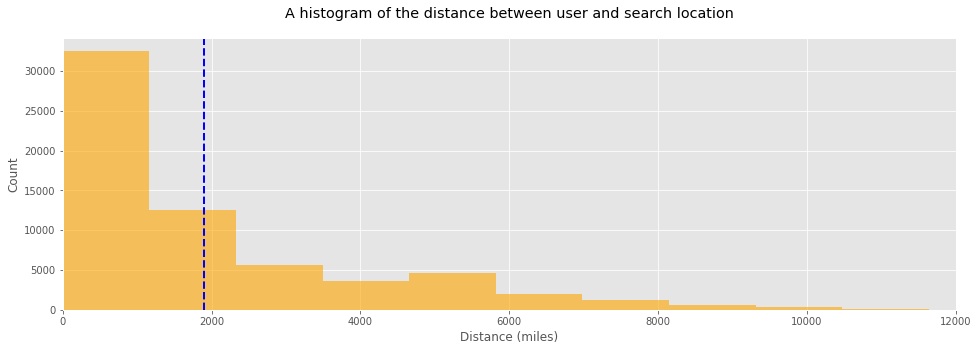

In [4]:
# set style
plt.style.use('ggplot')

#set figure
fig, ax = plt.subplots(figsize=(16, 5))

# set plot 
ax.hist(train["orig_destination_distance"], color = 'orange', alpha = 0.6)
ax.set_title('A histogram of the distance between user and search location', pad = 20)

#set labels
ax.set_xlim([0,12000])
ax.set_xlabel('Distance (miles)')
ax.set_ylabel('Count')
ax.axvline(train['orig_destination_distance'].mean(), color='blue', linestyle='dashed', linewidth = 2);

Most users do not use mobile or buy packages. 

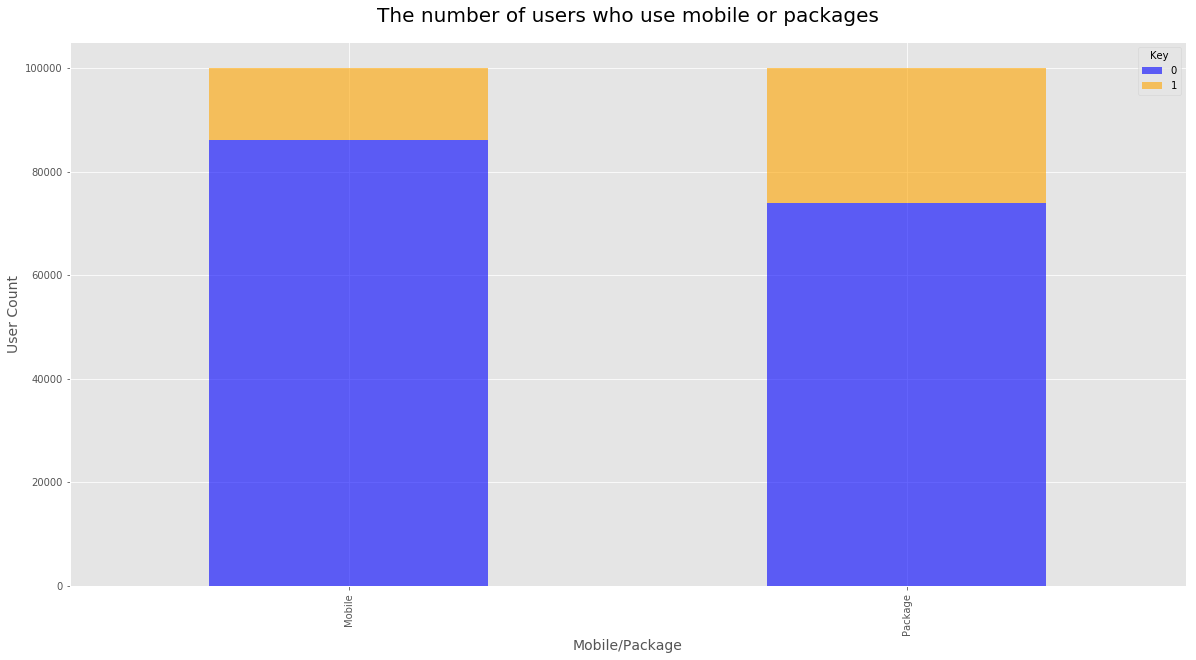

In [33]:
# count values for mobile and packages
x,y = train.is_mobile.value_counts()
a,b = train.is_package.value_counts()

# initialize list of lists 
data = [[x, a], [y, b]] 
  
# Create df
df = pd.DataFrame(data, columns = ['Mobile', 'Package']) 
df = df.T 

# set figure 
fig, ax = plt.subplots(figsize=(20,10))
df.plot(kind='bar', stacked=True, alpha=0.6, ax=ax, colors=['blue', 'orange'])

#set labels
ax.set_ylabel('User Count', fontsize = 14)
ax.set_xlabel('Mobile/Package', fontsize = 14)
ax.set_title('The number of users who use mobile or packages', fontsize=20, pad = 20)
ax.legend(title = 'Key', fontsize = 10);

There are many bookings with no children and many with 2 adults.

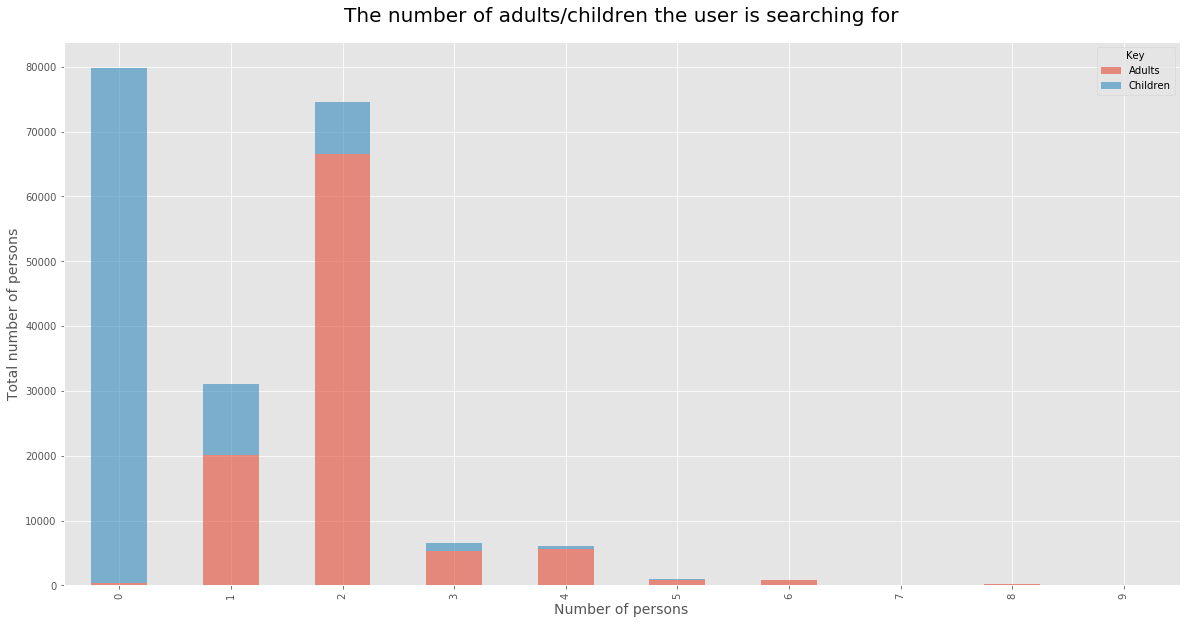

In [86]:
num_adult = list(train['srch_adults_cnt'].value_counts().sort_index())
num_child = list(train['srch_children_cnt'].value_counts().sort_index())
lst = list(range(0,10))

# initialize list of lists 
data = [num_adult, num_child] 
  
# Create df
df = pd.DataFrame(data, columns = lst) 
df = df.T 
df.columns = ['Adults', 'Children']

# set figure 
fig, ax = plt.subplots(figsize=(20,10))
df.plot(kind='bar', stacked=True, alpha=0.6, ax=ax)

#set labels
ax.set_ylabel('Total number of persons', fontsize = 14)
ax.set_xlabel('Number of persons', fontsize = 14)
ax.set_title('The number of adults/children the user is searching for', fontsize=20, pad = 20)
ax.legend(title = 'Key', fontsize = 10);

Below we can see that none of the variables are highly correlated with the 'hotel_cluster' feature, this implies that a linear method would perform poorly. 

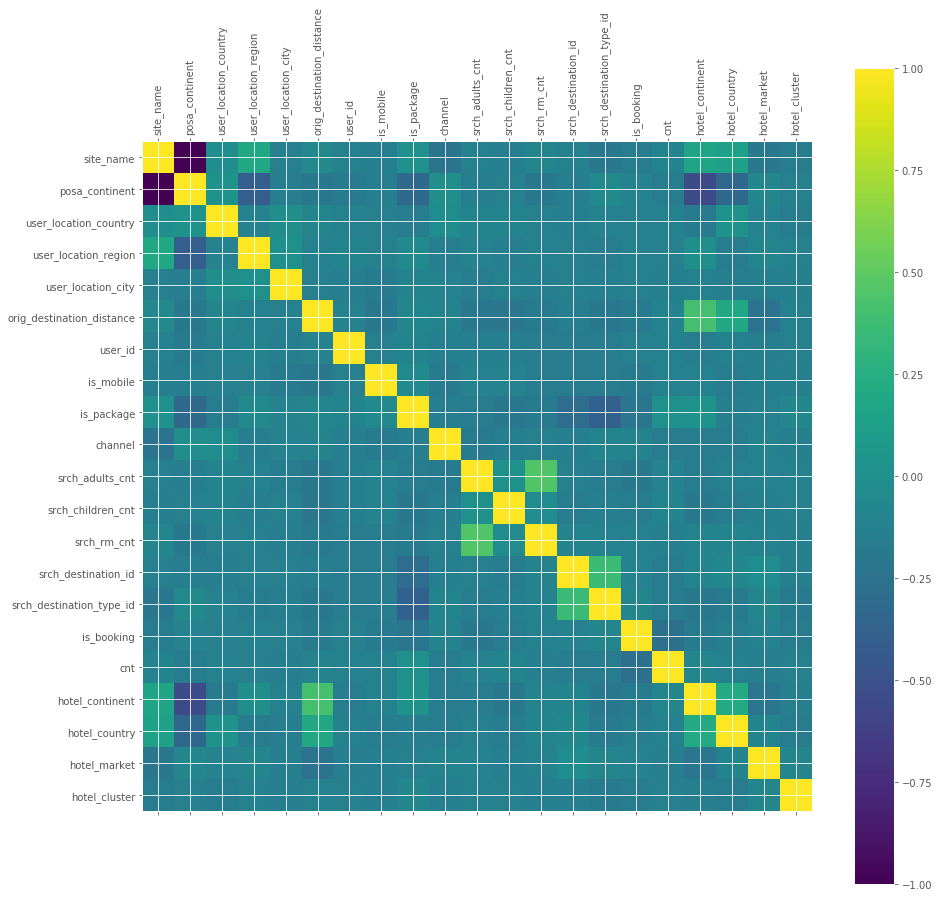

In [99]:
def plot_corr(df,size, labels):
    '''Function plots a graphical correlation matrix for each pair of columns in the dataframe.
    Takes dataframe and vertical/horizontal size of plot as inputs.
    Takes the column lables as an input.
    Note the correlation matrix automatically removes categorical variables.'''

    # set figure
    fig, ax = plt.subplots(figsize=(size, size))
    
    # set plot
    corr = df.corr()
    
    # labels and colours
    cax = ax.matshow(corr, vmin=-1, vmax=1)
    fig.colorbar(cax)
    ax.matshow(corr)
    plt.xticks(range(len(corr.columns)), corr.columns);
    plt.yticks(range(len(corr.columns)), corr.columns);
    #ax.set_title("Correlation Matrix for training data features", fontsize = 25 )
    ax.set_xticklabels(labels, rotation=90)

numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']    
labels = list(train.select_dtypes(include=numerics).columns)    

plot_corr(train, 15, labels)

## Data cleaning and feature engineering 

Now that we have explored the data let us try and predict the hotel cluster for the test dataset. This a multi-class classification problem. Before conducting any analysis data cleaning and feature engineering will be required. The steps in this section will be:

- remove users that did not book
- remove NaN values
- convert date columns to datetime variables
- Make features for year and month
- Make a feature for the differnece between the check-in and check-out day
- Drop irrelevant columns
- Merge the destinations and training data on 'srch_destination_id'
- drop NaN values

In [4]:
# only take users who booked
train = train.loc[train['is_booking'] == 1]
len(train)

8270

The white horizonatal bars in the visulisation below indicate where missing values in the data are. Clearly there are many NaN values for the 'orig_destination_distance' feature. These will be removed. This was chosen over methods such as replacing NaN values with the mean or predicting the missing values as 1) there is sufficient data, 2) using the mean can artifically reduce the variance of the data. 

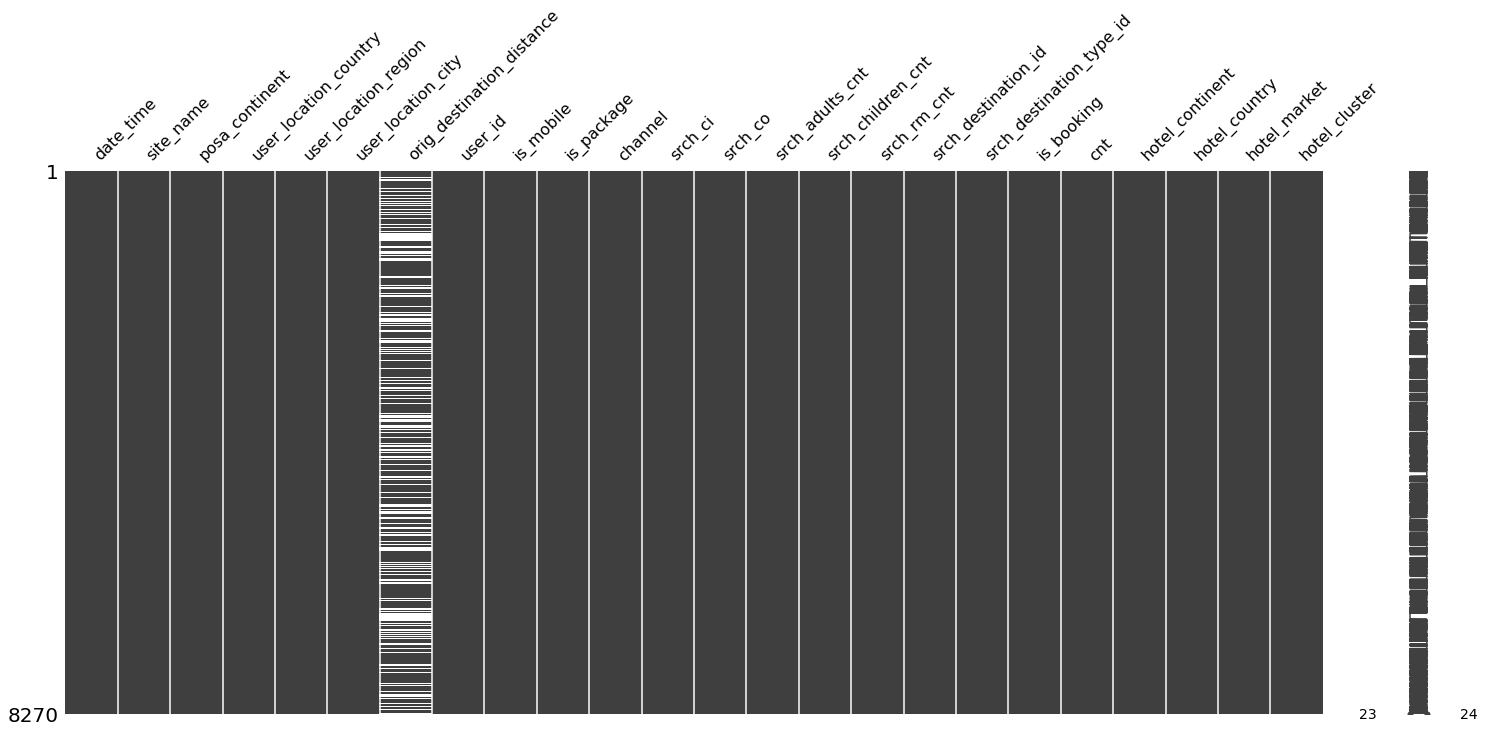

In [5]:
msno.matrix(train);

In [6]:
# check for null values
print(train.isnull().values.any())
train.isnull().sum()

True


date_time                       0
site_name                       0
posa_continent                  0
user_location_country           0
user_location_region            0
user_location_city              0
orig_destination_distance    2817
user_id                         0
is_mobile                       0
is_package                      0
channel                         0
srch_ci                         0
srch_co                         0
srch_adults_cnt                 0
srch_children_cnt               0
srch_rm_cnt                     0
srch_destination_id             0
srch_destination_type_id        0
is_booking                      0
cnt                             0
hotel_continent                 0
hotel_country                   0
hotel_market                    0
hotel_cluster                   0
dtype: int64

In [7]:
# remove null values. 
train.dropna(inplace = True)
print(len(train))
train.isnull().sum()

5453


date_time                    0
site_name                    0
posa_continent               0
user_location_country        0
user_location_region         0
user_location_city           0
orig_destination_distance    0
user_id                      0
is_mobile                    0
is_package                   0
channel                      0
srch_ci                      0
srch_co                      0
srch_adults_cnt              0
srch_children_cnt            0
srch_rm_cnt                  0
srch_destination_id          0
srch_destination_type_id     0
is_booking                   0
cnt                          0
hotel_continent              0
hotel_country                0
hotel_market                 0
hotel_cluster                0
dtype: int64

In [8]:
# convert date columns to datetime
train['date_time'] = pd.to_datetime(train['date_time'])
train['srch_ci'] = pd.to_datetime(train['srch_ci'])
train['srch_co'] = pd.to_datetime(train['srch_co'])

# make features for year and month
train['year'], train['month'], train['day'] = train['date_time'].dt.year, train['date_time'].dt.month, train['date_time'].dt.day

# create new feature for differnce between check in and check out day
train['ci_co'] = train['srch_co'] - train['srch_ci']
train['ci_co'] = train['ci_co'].apply(lambda x: int(x / np.timedelta64(1,'D')))

In [9]:
# drop irrelevant columns
del train['date_time']
del train['srch_ci']
del train['srch_co']
del train['is_booking']

In [10]:
# import destinations dataset
destinations = pd.read_csv("destinations.csv")
destinations.head(3)

,srch_destination_id,d1,d2,d3,d4,d5,d6,d7,d8,d9,d10,d11,d12,d13,d14,d15,d16,d17,d18,d19,d20,d21,d22,d23,d24,d25,d26,d27,d28,d29,d30,d31,d32,d33,d34,d35,d36,d37,d38,d39,d40,d41,d42,d43,d44,d45,d46,d47,d48,d49,d50,d51,d52,d53,d54,d55,d56,d57,d58,d59,d60,d61,d62,d63,d64,d65,d66,d67,d68,d69,d70,d71,d72,d73,d74,d75,d76,d77,d78,d79,d80,d81,d82,d83,d84,d85,d86,d87,d88,d89,d90,d91,d92,d93,d94,d95,d96,d97,d98,d99,d100,d101,d102,d103,d104,d105,d106,d107,d108,d109,d110,d111,d112,d113,d114,d115,d116,d117,d118,d119,d120,d121,d122,d123,d124,d125,d126,d127,d128,d129,d130,d131,d132,d133,d134,d135,d136,d137,d138,d139,d140,d141,d142,d143,d144,d145,d146,d147,d148,d149
0,0,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-1.897627,-2.198657,-2.198657,-1.897627,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-1.897627,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-1.897627,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-1.897627,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-1.897627,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-1.897627,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-1.897627,-2.198657,-2.198657,-2.198657,-1.897627,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657
1,1,-2.181690,-2.181690,-2.181690,-2.082564,-2.181690,-2.165028,-2.181690,-2.181690,-2.031597,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.043789,-2.181690,-2.181690,-2.181690,-2.165028,-2.181690,-2.133508,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.133508,-2.181690,-2.181690,-2.181690,-2.181690,-2.082564,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.165028,-2.165028,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.082564,-2.181690,-2.133508,-2.181690,-2.181690,-2.181690,-2.181690,-2.082564,-2.181690,-2.181690,-2.181690,-2.181690,-2.165028,-2.181690,-2.181690,-2.181690,-2.181690,-2.148982,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.133508,-2.181690,-2.181690,-2.181690,-2.181690,-2.181690,-2.133508,-2.181690,-2.181690,-2.181690,-2.148982,-2.181690,-2.181690,-2.181690,-2.181690,-2.148982,-2.181690,-2.181690,-2.165028,-2.181690,-2.165028,-2.181690,-2.181690,-2.165028,-2.181690,-2.181690,-2.181690,-2.181690
2,2,-2.183490,-2.224164,-2.224164,-2.189562,-2.105819,-2.075407,-2.224164,-2.118483,-2.140393,-2.224164,-2.209855,-2.224164,-2.110723,-2.186008,-2.224164,-2.124474,-2.224164,-2.156467,-2.224164,-2.224164,-2.224164,-2.224164,-2.224164,-2.224164,-2.224164,-2.224164,-2.224164,-2.224164,-2.153316,-2.186008,-2.224164,-2.224164,-2.224164,-2.128237,-2.158309,

In [11]:
# merge both training and destinations df on search destination ID
train = pd.merge(train, destinations, on='srch_destination_id')
train.shape

(5435, 173)

In [12]:
# drop NaN values
train.isnull().sum()
train.dropna(inplace = True)
train.shape

(5435, 173)

In [13]:
# view training dataset
train.head(3)

,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,channel,srch_adults_cnt,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster,year,month,day,ci_co,d1,d2,d3,d4,d5,d6,d7,d8,d9,d10,d11,d12,d13,d14,d15,d16,d17,d18,d19,d20,d21,d22,d23,d24,d25,d26,d27,d28,d29,d30,d31,d32,d33,d34,d35,d36,d37,d38,d39,d40,d41,d42,d43,d44,d45,d46,d47,d48,d49,d50,d51,d52,d53,d54,d55,d56,d57,d58,d59,d60,d61,d62,d63,d64,d65,d66,d67,d68,d69,d70,d71,d72,d73,d74,d75,d76,d77,d78,d79,d80,d81,d82,d83,d84,d85,d86,d87,d88,d89,d90,d91,d92,d93,d94,d95,d96,d97,d98,d99,d100,d101,d102,d103,d104,d105,d106,d107,d108,d109,d110,d111,d112,d113,d114,d115,d116,d117,d118,d119,d120,d121,d122,d123,d124,d125,d126,d127,d128,d129,d130,d131,d132,d133,d134,d135,d136,d137,d138,d139,d140,d141,d142,d143,d144,d145,d146,d147,d148,d149
0,2,3,66,348,48862,2234.2641,12,0,1,9,2,0,1,8250,1,1,2,50,628,1,2014,8,11,4,-2.283946,-2.346645,-2.400912,-2.36719,-2.273226,-1.722868,-2.392862,-2.381387,-2.239271,-2.259266,-2.305731,-2.400912,-2.369545,-1.712277,-2.399467,-1.901553,-2.065535,-2.384672,-2.399649,-1.140066,-2.354545,-2.400596,-2.400912,-2.365183,-2.397435,-2.365331,-2.397981,-2.36363,-1.675819,-2.194497,-2.400912,-2.399802,-2.398695,-2.392615,-2.209667,-2.317894,-1.281688,-2.398314,-2.37445,-2.370005,-2.031847,-2.38759,-1.645141,-2.400912,-2.37857,-2.364266,-2.397885,-2.355131,-1.349492,-2.3731,-2.3975,-2.348903,-2.241532,-2.400534,-2.207067,-2.305964,-2.397016,-2.241567,-2.393153,-2.399966,-2.38017,-2.391761,-2.399015,-2.400506,-2.400912,-2.363137,-2.395585,-2.396456,-2.391947,-2.400912,-2.356842,-2.379234,-2.393781,-1.967871,-1.960995,-2.399409,-2.333032,-2.38558,-2.257085,-2.316076,-2.39186,-2.397906,-2.372328,-2.079968,-2.220271,-2.400912,-2.399502,-2.387979,-2.392953,-2.400396,-1.938336,-2.396843,-1.366535,-2.381904,-2.396208,-2.306028,-2.399802,-2.398006,-2.385102,-2.400912,-2.387891,-2.340923,-2.359161,-2.336553,-2.364671,-2.396077,-2.280828,-1.760466,-2.371376,-2.389435,-2.36865,-2.392657,-2.397517,-2.356602,-2.399802,-2.397591,-2.39211,-2.394294,-2.398695,-2.392041,-1.925548,-1.868743,-2.400912,-2.389131,-2.390027,-2.363872,-2.396035,-2.007101,-2.400837,-2.120344,-2.27519,-2.203799,-2.373795,-2.365093,-2.400912,-2.370761,-2.343093,-2.320423,-1.73264,-2.384553,-2.345528,-2.396591,-2.399953,-2.388116,-2.394294,-2.400667,-2.398716,-2.386585,-2.39037
1,13,1,46,171,15334,5655.3159,4539,0,0,9,2,2,1,8250,1,2,2,50,628,1,2013,11,20,2,-2.283946,-2.346645,-2.400912,-2.36719,-2.273226,-1.722868,-2.392862,-2.381387,-2.239271,-2.259266,-2.305731,-2.400912,-2.369545,-1.712277,-2.399467,-1.901553,-2.065535,-2.384672,-2.399649,-1.140066,-2.354545,-2.400596,-2.400912,-2.365183,-2.397435,-2.365331,-2.397981,-2.36363,-1.675819,-2.194497,-2.400912,-2.399802,-2.398695,-2.392615,-2.209667,-2.317894,-1.281688,-2.398314,-2.37445,-2.370005,-2.031847,-2.38759,-1.645141,-2.400912,-2.37857,-2.364266,-2.397885,-2.355131,-1.349492,-2.3731,-2.3975,-2.348903,-2.241532,-2.400534,-2.207067,-2.305964,-2.397016,-2.241567,-2.393153,-2.399966,-2.38017,-2.391761,-2.399015,-2.400506,-2.400912,-2.363137,-2.395585,-2.396456,-2.391947,-2.400912,-2.356842,-2.379234,-2.393781,-1.967871,-1.960995,-2.399409,-2.333032,-2.38558,-2.257085,-2.316076,-2.39186,-2.397906,-2.372328,-2.079968,-2.220271,-2.400912,-2.399502,-2.387979,-2.392953,-2.400396,-1.938336,-2.396843,-1.366535,-2.381904,-2.396208,-2.306028,-2.399802,-2.398006,-2.385102,-2.400912,-2.387891,-2.340923,-2.359161,-2.336553,-2.364671,-2.396077,-2.280828,-1.760466,-2.371376,-2.389435,-2.36865,-2.392657,-2.397517,-2.356602,-2.399802,-2.397591,-2.39211,-2.394294,-2.398695,-2.392041,-1.925548,-1.868743,-2.400912,-2.389131,-2.390027,-2.363872,-2.396035,-2.007101,-2.400837,-2.120344,-2.27519,-2.203799,-2.373795,-2.365093,-2.400912,-2.370761,-2.343093,-2.320423,-1.73264,-2.384553,-2.345528,-2.396591,-2.399

## Data analysis

Now that we have cleaned and feature engineered the dataset, let us predict the hotel cluster of user searches the test data. The steps in this section are:

- check if the target class ('hotel_cluster') is balanced
- split the training data into a training and validation set 
- rescale the features
- train machine learning classification algorithms and select best performing classifier
- import, clean and feature engineer the test dataset
- use the best performing classifier to predict the hotel cluster of searches in the test dataset. 
- export the predictions as a csv file

The below shows that the target class is not balanced. Therefore, we cannot use accuracy when computing the performance metrics of the classifier. As we will see later, the balanced accuracy score is computed instead. This takes into account for the class imbalance in binary and multi-class classification problems. 

In [14]:
# check if the target class ('hotel_cluster') is balanced
x = list(train['hotel_cluster'])

from collections import Counter
counts = Counter(sorted(x))
 
# show first 20    
for key in sorted(counts)[:20]:
    print (key, counts[key])

0 36
1 79
2 75
3 22
4 75
5 59
6 92
7 80
8 34
9 87
10 81
11 46
12 6
13 100
14 27
15 60
16 119
17 32
18 138
19 82


In [15]:
# create X and Y
y = np.array(train['hotel_cluster'])
X = np.array(train.loc[:, train.columns != 'hotel_cluster'])

# create training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2)

Higher magnitude features can have a greater effect in some models. As some features vary in magnitude they are rescaled to minimise these effects.

In [16]:
# rescale features
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [17]:
# train classifiers and compute the balanced accuracy score

# logistic regression
logreg = LogisticRegression(solver='lbfgs', multi_class='auto', max_iter = 2000).fit(X_train, y_train)
pred = logreg.predict(X_test)

print('Accuracy: ' + str(round(balanced_accuracy_score(y_test,pred), 3)))

Accuracy: 0.092


In [18]:
# decision trees
clf = DecisionTreeClassifier().fit(X_train, y_train)
pred = clf.predict(X_test)

print('Accuracy: ' + str(round(balanced_accuracy_score(y_test,pred), 3)))

Accuracy: 0.193


In [167]:
#knn
knn = KNeighborsClassifier().fit(X_train, y_train)
pred = knn.predict(X_test)

print('Accuracy: ' + str(round(balanced_accuracy_score(y_test,pred), 3)))

Accuracy: 0.102


C:\Paresh\Anaconda1\lib\site-packages\sklearn\metrics\classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


In [172]:
#lda
lda = LinearDiscriminantAnalysis().fit(X_train, y_train)
pred = lda.predict(X_test)

print('Accuracy: ' + str(round(balanced_accuracy_score(y_test,pred), 3)))

Accuracy: 0.165


C:\Paresh\Anaconda1\lib\site-packages\sklearn\metrics\classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


In [169]:
#naive bayes
gnb = GaussianNB().fit(X_train, y_train)
pred = gnb.predict(X_test)

print('Accuracy: ' + str(round(balanced_accuracy_score(y_test,pred), 3)))

Accuracy: 0.109


In [170]:
#support vector machines
svm = SVC(gamma='auto').fit(X_train, y_train)
pred = svm.predict(X_test)

print('Accuracy: ' + str(round(balanced_accuracy_score(y_test,pred), 3)))

Accuracy: 0.03


In [222]:
#extreme gradient boosting

#convert to DMatrix object
DM_train = xgb.DMatrix(data = X_train, 
                       label = y_train)
  
DM_test = xgb.DMatrix(data = X_test,
                       label = y_test)

#set parameters and predict model
param   = {'max_depth':2, 'eta':1, 'silent':1} 
xgmodel = xgb.train(param, DM_train, num_boost_round = 2)                    
pred = xgmodel.predict(DM_test) 

print('Accuracy: ' + str(round(balanced_accuracy_score(y_true = y_test, 
                          y_pred = pred.round()), 3)))

Accuracy: 0.011


In [243]:
# get confusion matrix and performance metrics for the best classifier 

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
pred = clf.predict(X_test)
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

[[3 0 0 ... 0 0 0]
 [0 6 0 ... 0 0 0]
 [0 0 3 ... 0 0 0]
 ...
 [0 0 0 ... 2 0 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 1 0]]
              precision    recall  f1-score   support

           0       0.50      0.38      0.43         8
           1       0.27      0.46      0.34        13
           2       0.12      0.25      0.17        12
           3       0.20      0.12      0.15         8
           4       0.00      0.00      0.00         8
           5       0.00      0.00      0.00        15
           6       0.10      0.20      0.13        15
           7       0.27      0.36      0.31        11
           8       0.00      0.00      0.00         7
           9       0.10      0.12      0.11        17
          10       0.24      0.22      0.23        18
          11       0.18      0.20      0.19        10
          12       0.00      0.00      0.00         2
          13       0.27      0.19      0.22        21
          14       0.00      0.00      0.00         9
          15   

C:\Paresh\Anaconda1\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Paresh\Anaconda1\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Paresh\Anaconda1\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Paresh\Anaconda1\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Paresh\Anaconda1\lib\site-packages\sklearn\metric

In [19]:
# see the top 5 most important features
lst = list(zip(train.columns, clf.feature_importances_))

lst.sort(key=lambda x: x[1], reverse = True)
lst[:5]

[('orig_destination_distance', 0.09018609325469992),
 ('user_id', 0.06884155760429315),
 ('user_location_city', 0.06472914385968809),
 ('month', 0.06393453659989837),
 ('year', 0.05176880481089275)]

In [247]:
# import test data
test = pd.read_csv("test.csv", nrows = 5000000)
test.head(3)

,id,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,channel,srch_ci,srch_co,srch_adults_cnt,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,hotel_continent,hotel_country,hotel_market
0,0,2015-09-03 17:09:54,2,3,66,174,37449,5539.0567,1,1,0,3,2016-05-19,2016-05-23,2,0,1,12243,6,6,204,27
1,1,2015-09-24 17:38:35,2,3,66,174,37449,5873.2923,1,1,0,10,2016-05-12,2016-05-15,2,0,1,14474,7,6,204,1540
2,2,2015-06-07 15:53:02,2,3,66,142,17440,3975.9776,20,0,0,1,2015-07-26,2015-07-27,4,0,1,11353,1,2,50,699


In [248]:
# remove null values. 
test.dropna(inplace = True)
print(len(test))
test.isnull().sum()

1680765


id                           0
date_time                    0
site_name                    0
posa_continent               0
user_location_country        0
user_location_region         0
user_location_city           0
orig_destination_distance    0
user_id                      0
is_mobile                    0
is_package                   0
channel                      0
srch_ci                      0
srch_co                      0
srch_adults_cnt              0
srch_children_cnt            0
srch_rm_cnt                  0
srch_destination_id          0
srch_destination_type_id     0
hotel_continent              0
hotel_country                0
hotel_market                 0
dtype: int64

In [249]:
# convert date columns to datetime
test['date_time'] = pd.to_datetime(test['date_time'])
test['srch_ci'] = pd.to_datetime(test['srch_ci'])
test['srch_co'] = pd.to_datetime(test['srch_co'])

# make features for year and month
test['year'], test['month'], test['day'] = test['date_time'].dt.year, test['date_time'].dt.month, test['date_time'].dt.day

# create new feature for differnce between check in and check out day
test['ci_co'] = test['srch_co'] - test['srch_ci']
test['ci_co'] = test['ci_co'].apply(lambda x: int(x / np.timedelta64(1,'D')))

In [250]:
# drop irrelevant columns
del test['date_time']
del test['srch_ci']
del test['srch_co']

In [251]:
# merge both df on search destination ID
test = pd.merge(test, destinations, on='srch_destination_id')
test.shape

(1660932, 172)

In [252]:
# predict the class of the test data
pred = clf.predict(test)

In [253]:
# see all of the unique classes searches were predicted to
set(pred)

{41, 69, 78}

In [259]:
# create df for id and pred 
id = list(test['id'])
df = pd.DataFrame({'id': id, 'hotel_cluster': pred})

In [262]:
# export to a csv file
df.to_csv('hotel_predictions')

# Conlusion

The classifier that was best at predicting the hotel cluster was decision trees. However, it should be noted that this classifier and the other classifiers did not perform particularly well at the prediction task. This may be because there are so many classes (100). Future work could consider the following improvements: 
- using the k-means alogorithm to further group hotel clusters together to improve prediction accuracy
- using PCA to reduce the number of features and thus speed up classification
- using more advanced algorithms
- improve feature engineering and data cleaning e.g. add another column for total number of people, remove users who book more than a certain number of times a year as they are likely to be travel agents

## References

https://medium.com/greyatom/why-how-and-when-to-scale-your-features-4b30ab09db5e